# Cell 1: Imports and Setup

In [24]:
%load_ext autoreload
%autoreload 2

import os
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D # For custom legend handles
from datetime import date # For type hinting if using dates
import logging

import pandas as pd
pd.set_option('display.max_columns', None)


# Configure logging (set level, format, etc.) - Basic example
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', force=True) # force=True might be needed in notebooks

# Add functions directory to path to import custom modules
# Assuming the notebook is run from the project root directory
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

import importlib
# Import the data fetching and loading functions
from functions.data_fetching.earthquake_data import fetch_and_load_earthquake_data
from functions.data_fetching.plate_data import load_plate_boundaries
from functions.data_fetching.natural_earth_downloader import load_natural_earth_data
# Import the plotting function
import functions.plotting

logging.info("Libraries and custom functions imported.")

2025-04-08 00:32:28,500 - INFO - Libraries and custom functions imported.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Cell 2: Define Parameters

In [2]:
# Define the minimum magnitude for earthquake data
min_eq_magnitude = 1.0

# Define target CRS (used by loading functions by default)
target_crs_epsg = "EPSG:4326"

# Define date range (optional, defaults in function are ~last year)
# Set to None if not using specific dates, otherwise define as string or date object
start_date = "2020-01-01" # Example: "2024-01-01" or date(2024, 1, 1)
end_date =  "2024-12-31"   # Example: "2024-12-31" or date(2024, 12, 31)

# Cell 3: Load Data using Functions

In [ ]:
# Load Earthquake Data
logging.info(f"Loading earthquake data (min magnitude: {min_eq_magnitude}, target CRS: {target_crs_epsg})...")
earthquake_gdf = fetch_and_load_earthquake_data(
    min_magnitude=min_eq_magnitude,
    target_crs=target_crs_epsg,
    start_date=start_date, # Pass defined start_date
    end_date=end_date      # Pass defined end_date
)
# drop columns we don't need
earthquake_gdf.drop(columns=['tz', 'url', 'detail','title', 'updated','sources','ids','types'], inplace=True)
if earthquake_gdf is not None:
    logging.info(f"-> Successfully loaded {len(earthquake_gdf)} earthquakes. CRS: {earthquake_gdf.crs}")
else:
    logging.error("-> Failed to load earthquake data.")

# Load Plate Boundary Data
logging.info(f"\nLoading tectonic plate boundary data (target CRS: {target_crs_epsg})...")
plate_gdf = load_plate_boundaries(target_crs=target_crs_epsg)
if plate_gdf is not None:
    logging.info(f"-> Successfully loaded {len(plate_gdf)} plate boundary features. CRS: {plate_gdf.crs}")
else:
    logging.error("-> Failed to load plate boundary data.")

# Load Natural Earth Data
logging.info(f"\nLoading Natural Earth 50m countries and 10m lakes data (target CRS: {target_crs_epsg})...")
natural_earth_data = load_natural_earth_data(target_crs=target_crs_epsg)
ne_countries_gdf = natural_earth_data.get('countries') # Changed key and variable name
ne_lakes_gdf = natural_earth_data.get('lakes')

if ne_countries_gdf is not None:
    logging.info(f"-> Successfully loaded {len(ne_countries_gdf)} countries. CRS: {ne_countries_gdf.crs}")
else:
    logging.error("-> Failed to load Natural Earth countries.")

if ne_lakes_gdf is not None:
    logging.info(f"-> Successfully loaded {len(ne_lakes_gdf)} lakes. CRS: {ne_lakes_gdf.crs}")
else:
    logging.error("-> Failed to load Natural Earth lakes.")

2025-04-08 00:00:47,053 - INFO - Loading earthquake data (min magnitude: 1.0, target CRS: EPSG:4326)...
2025-04-08 00:00:47,054 - INFO - Processing earthquake data from 2020-01-01 to 2024-12-31 (inclusive)...
2025-04-08 00:00:47,159 - INFO - All daily files already exist locally.
2025-04-08 00:00:47,160 - INFO - Loading daily GeoJSON files...
2025-04-08 00:02:47,462 - INFO - Concatenating data from 1827 daily files...
c:\Users\Hannah Miller Young\OneDrive\Documents\GE3250 Computational Geoscience\hannah_miller_term_project\functions\data_fetching\earthquake_data.py:219: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_gdf = pd.concat(daily_gdfs, ignore_index=True)
2025-04-08 00:02:48,941 - INFO - Successfully loaded and combined 55278

# Cell 4: Check Loaded Data

In [4]:
# Verify if essential data for plotting was loaded successfully
can_plot_plates_eq = all(gdf is not None for gdf in [plate_gdf, earthquake_gdf])
can_plot_ne = all(gdf is not None for gdf in [ne_countries_gdf, ne_lakes_gdf]) # Basemap is optional, updated variable

if not can_plot_plates_eq:
    logging.error("Error: Cannot proceed with plotting as Plate Boundary or Earthquake data failed to load.")
else:
    logging.info("Essential data (Plates, Earthquakes) loaded successfully.")
    if not can_plot_ne:
        logging.warning("Warning: Natural Earth basemap data failed to load. Plot will be generated without basemap.")
    else:
        logging.info("Natural Earth basemap data loaded successfully.")

2025-04-08 00:02:53,065 - INFO - Essential data (Plates, Earthquakes) loaded successfully.
2025-04-08 00:02:53,066 - INFO - Natural Earth basemap data loaded successfully.


In [45]:
earthquake_gdf.utm_epsg.nunique()

120

In [34]:
from shapely.geometry import Point
import geopandas as gpd
import math
import swifter # Import swifter to add .swifter before apply in pandas/geopandas for parallel execution 

# Make our earthquake location with a depth a 2d point. be efficient for testing and only do this if we haven't done it before
if not earthquake_gdf.empty and hasattr(earthquake_gdf['geometry'].iloc[0], 'has_z') and earthquake_gdf['geometry'].iloc[0].has_z:
    logging.info("earthquake_gdf geometry is 3D. Converting to 2D.")
    earthquake_gdf['geometry'] = earthquake_gdf.geometry.swifter.apply(lambda geom: Point(geom.x, geom.y) if geom else None)
else:
    logging.info("earthquake_gdf geometry is not 3D. Skipping conversion.")

# Calculate the UTM zone and EPSG for each row
def get_utm_info(row):
    """
    Calculates the UTM zone and approximate EPSG code for a given geometry point (lat/lon).
    Assumes the geometry is in EPSG:4326.
    """
    # Ensure it's a Point geometry
    if not isinstance(row.geometry, Point):
        return None, None # Or raise an error, or return default

    # Get longitude and latitude
    lon = row.geometry.x
    lat = row.geometry.y

    # Calculate UTM zone number
    # Zones are 6 degrees wide, starting from 180W (-180)
    # Zone 1: -180 to -174, Zone 2: -174 to -168, ..., Zone 31: 0 to 6, ..., Zone 60: 174 to 180
    zone_number = math.floor(((lon + 180) / 6) % 60) + 1 # %60 handles the 180 longitude edge case

    # Determine hemisphere (North or South)
    hemisphere = 'N' if lat >= 0 else 'S'

    # Construct UTM zone string
    utm_zone_str = f"{zone_number}{hemisphere}"

    # Determine EPSG code base (WGS 84 UTM)
    # 326xx for North, 327xx for South
    epsg_base = 32600 if lat >= 0 else 32700
    utm_epsg = epsg_base + zone_number

    return utm_zone_str, f'EPSG:{utm_epsg}'

# Apply the function row-wise using swifter
# Replace '.apply' with '.swifter.apply'
# Keep axis=1 for row-wise operation.
# swifter doesn't use result_type='expand' directly in the apply call.
# Pandas handles the assignment of the resulting Series of tuples to multiple columns.
logging.info("Calculating UTM info using swifter...")
result_series = earthquake_gdf.swifter.apply(
    get_utm_info,
    axis=1
)

# Assign the results (which is a Series of tuples) to the new columns
earthquake_gdf[['utm_zone', 'utm_epsg']] = gpd.GeoDataFrame(result_series.tolist(), index=earthquake_gdf.index)

print("\nCalculation complete.")
earthquake_gdf.head(2)

2025-04-08 00:36:11,599 - INFO - First geometry is 2D or DataFrame empty/invalid. Skipping conversion.
2025-04-08 00:36:11,599 - INFO - Calculating UTM info using swifter...


Pandas Apply:   0%|          | 0/552787 [00:00<?, ?it/s]


Calculation complete.


,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg
0,ak02021ksej,1.30,"38 km SE of Tanana, Alaska",1577923094766,NaN,NaN,NaN,None,reviewed,0,26,ak,02021ksej,NaN,NaN,0.81,NaN,ml,earthquake,POINT (-151.5952 64.8922),2020-01-01,5N,EPSG:32605
1,nc73322376,1.63,"10km ENE of Blackhawk, CA",1577922964240,NaN,NaN,NaN,None,reviewed,0,41,nc,73322376,24.0,0.03565,0.09,129.0,md,earthquake,POINT (-121.79433 37.8455),2020-01-01,10N,EPSG:32610


In [62]:
import pandas as pd # Added for pd.isna
from shapely.geometry import Point
import geopandas as gpd
import math
import swifter # Import swifter
import logging # Make sure logging is configured elsewhere


# Make our earthquake location with a depth a 2d point. be efficient for testing and only do this if we haven't done it before
if not earthquake_gdf.empty and 'geometry' in earthquake_gdf.columns and earthquake_gdf['geometry'].iloc[0] is not None and hasattr(earthquake_gdf['geometry'].iloc[0], 'has_z') and earthquake_gdf['geometry'].iloc[0].has_z:
    logging.info("earthquake_gdf geometry is 3D. Converting to 2D.")
    # Ensure we only apply to actual geometry objects, handle None
    earthquake_gdf['geometry'] = earthquake_gdf['geometry'].swifter.apply(
        lambda geom: Point(geom.x, geom.y) if geom and hasattr(geom, 'x') else None
    )
else:
    logging.info("earthquake_gdf geometry is not 3D or conversion not needed. Skipping conversion.")

# --- Modified Function ---
def get_utm_info_and_reproject(row, source_crs):
    """
    Calculates the UTM zone, EPSG code, and reprojects the geometry
    for a given row. Assumes the geometry is in a geographic CRS.
    Returns a tuple: (utm_zone_str, utm_epsg_str, utm_geometry).
    """
    # Default return values in case of issues
    utm_zone_str = None
    utm_epsg_str = None
    utm_geometry = None

    # Ensure it's a Point geometry and not None
    if not isinstance(row.geometry, Point) or pd.isna(row.geometry):
        return utm_zone_str, utm_epsg_str, utm_geometry # Return None tuple

    # Get longitude and latitude
    lon = row.geometry.x
    lat = row.geometry.y

    # Handle potential invalid coordinates outside typical lat/lon ranges if necessary
    if not (-180 <= lon <= 180 and -90 <= lat <= 90):
         logging.warning(f"Coordinates ({lon}, {lat}) outside standard range at index {row.name}. Skipping UTM calculation and projection.")
         return utm_zone_str, utm_epsg_str, utm_geometry # Return None tuple

    try:
        # Calculate UTM zone number
        zone_number = math.floor(((lon + 180) / 6) % 60) + 1

        # Determine hemisphere (North or South)
        hemisphere = 'N' if lat >= 0 else 'S'

        # Construct UTM zone string
        utm_zone_str = f"{int(zone_number)}{hemisphere}" # Ensure zone_number is int

        # Determine EPSG code base (WGS 84 UTM)
        epsg_base = 32600 if lat >= 0 else 32700
        utm_epsg = epsg_base + int(zone_number)
        utm_epsg_str = f'EPSG:{utm_epsg}'

        # --- Reprojection Step ---
        # Create a temporary GeoSeries with the single geometry and original CRS
        temp_gs = gpd.GeoSeries([row.geometry], crs=source_crs)
        # Reproject to the target UTM CRS
        reprojected_gs = temp_gs.to_crs(utm_epsg_str) # Use the calculated EPSG string
        # Get the reprojected Shapely geometry object
        utm_geometry = reprojected_gs.iloc[0]

    except Exception as e:
        # Log error if calculation or reprojection fails
        logging.error(f"Failed UTM calculation or reprojection at index {row.name} for geom {row.geometry} to {utm_epsg_str}. Error: {e}")
        # Return None tuple in case of error
        return None, None, None

    return utm_zone_str, utm_epsg_str, utm_geometry

# --- Modified Apply Call ---
logging.info("Calculating UTM info and reprojecting geometry using swifter...")

# Apply the combined function row-wise using swifter
# Pass the source_crs as an argument
earthquake_with_utm_gdf = earthquake_gdf[:50].copy()
result_series = earthquake_with_utm_gdf.swifter.apply(
    get_utm_info_and_reproject,
    source_crs=earthquake_gdf.crs, # Pass the source CRS here
    axis=1
)
earthquake_with_utm_gdf[['utm_zone', 'utm_epsg', 'utm_geometry']] = gpd.GeoDataFrame(
    result_series.tolist(),
    index=result_gdf.index
)


2025-04-08 01:33:44,151 - INFO - earthquake_gdf geometry is not 3D or conversion not needed. Skipping conversion.
2025-04-08 01:33:44,156 - INFO - Calculating UTM info and reprojecting geometry using swifter...


Pandas Apply:   0%|          | 0/50 [00:00<?, ?it/s]

In [63]:
result_gdf.head()

,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,utm_geometry
0,ak02021ksej,1.30,"38 km SE of Tanana, Alaska",1577923094766,NaN,NaN,NaN,None,reviewed,0,26,ak,02021ksej,NaN,NaN,0.81,NaN,ml,earthquake,POINT (-151.5952 64.8922),2020-01-01,5N,EPSG:32605,POINT (566508.2623993153 7197178.920848711)
1,nc73322376,1.63,"10km ENE of Blackhawk, CA",1577922964240,NaN,NaN,NaN,None,reviewed,0,41,nc,73322376,24.0,0.03565,0.09,129.0,md,earthquake,POINT (-121.79433 37.8455),2020-01-01,10N,EPSG:32610,POINT (606077.9638517055 4189357.967278359)
2,nc73322371,1.46,"14km S of Tres Pinos, CA",1577922767220,NaN,NaN,NaN,None,reviewed,0,33,nc,73322371,20.0,0.04473,0.07,88.0,md,earthquake,POINT (-121.2945 36.67067),2020-01-01,10N,EPSG:32610,POINT (652407.1467748537 4059694.2764252787)
3,pr2020001292,1.56,"7 km SW of Tallaboa, Puerto Rico",1577922752460,NaN,NaN,NaN,None,reviewed,0,37,pr,2020001292,3.0,0.12060,0.17,351.0,md,earthquake,POINT (-66.7623 17.9455),2020-01-01,19N,EPSG:32619,POINT (737010.5971063226 1985582.428257147)
4,pr2020001291,1.78,"6 km SSE of Guánica, Puerto Rico",1577922719530,NaN,NaN,NaN,None,reviewed,0,49,pr,2020001291,4.0,0.06170,0.62,275.0,md,earthquake,POINT (-66.884 17.9136),2020-01-01,19N,EPSG:32619,POINT (724155.7383510026 1981900.1717897344)


In [35]:
plate_gdf[['strnum','platecode','geogdisc','boundary_t']].head(2)

,strnum,platecode,datatype,dtnum,refnum,appearance,disappeara,color,geogdesc,boundary_t,Id,geometry
0,2,201,RI,1,9921,0.1,-999.0,7,SOUTH ATLANTIC RIDGE,ridge,NaN,"LINESTRING (-40.6742 9.8782, -40.6736 9.7647, ..."
1,3,101,RI,1,9201,0.1,-999.0,1,NORTH & CENTRAL ATLANTIC RIDGE AXIS,ridge,NaN,"LINESTRING (-32.2971 37.4118, -32.3909 37.1394..."


In [42]:
import geopandas as gpd
from functions.spatial_analysis import calculate_distance_to_plate

earthquake_gdf_with_distances = calculate_distance_to_plate(earthquake_gdf[:50], plate_gdf)

earthquake_gdf_with_distances.head()

--- Starting calculate_distance_to_plate ---
[calculate_distance_to_plate] Input earthquake CRS: EPSG:4326
[calculate_distance_to_plate] Input plates CRS: EPSG:4326

[calculate_distance_to_plate] Found 12 unique raw UTM EPSG values to process.

[calculate_distance_to_plate] Processing zone with EPSG:32605 (from raw value: 'EPSG:32605')...
  [calculate_distance_to_plate] Found 3 earthquakes for raw value 'EPSG:32605' (EPSG:32605).
  [calculate_distance_to_plate] Reprojecting 3 earthquakes from EPSG:4326 to EPSG:32605...
    Earthquake subset reprojected. New CRS: EPSG:32605
  [calculate_distance_to_plate] Reprojecting 514 plate boundaries from EPSG:4326 to EPSG:32605...
    Plate boundaries reprojected. New CRS: EPSG:32605
  [calculate_distance_to_plate] Warning: Found 4 invalid geometries in projected plates for EPSG:32605.
  [calculate_distance_to_plate] Calculating nearest plates using sjoin_nearest for 3 earthquakes and 514 plates...
    sjoin_nearest completed. Result has 3 rows.
 

,id,mag,place,time,felt,cdi,mmi,alert,status,tsunami,sig,net,code,nst,dmin,rms,gap,magType,type,geometry,source_date,utm_zone,utm_epsg,distance_to_plate,closest_plate_strnum
0,ak02021ksej,1.30,"38 km SE of Tanana, Alaska",1577923094766,NaN,NaN,NaN,None,reviewed,0,26,ak,02021ksej,NaN,NaN,0.81,NaN,ml,earthquake,POINT (-151.5952 64.8922),2020-01-01,5N,EPSG:32605,NaN,<NA>
1,nc73322376,1.63,"10km ENE of Blackhawk, CA",1577922964240,NaN,NaN,NaN,None,reviewed,0,41,nc,73322376,24.0,0.03565,0.09,129.0,md,earthquake,POINT (-121.79433 37.8455),2020-01-01,10N,EPSG:32610,NaN,<NA>
2,nc73322371,1.46,"14km S of Tres Pinos, CA",1577922767220,NaN,NaN,NaN,None,reviewed,0,33,nc,73322371,20.0,0.04473,0.07,88.0,md,earthquake,POINT (-121.2945 36.67067),2020-01-01,10N,EPSG:32610,NaN,<NA>
3,pr2020001292,1.56,"7 km SW of Tallaboa, Puerto Rico",1577922752460,NaN,NaN,NaN,None,reviewed,0,37,pr,2020001292,3.0,0.12060,0.17,351.0,md,earthquake,POINT (-66.7623 17.9455),2020-01-01,19N,EPSG:32619,NaN,<NA>
4,pr2020001291,1.78,"6 km SSE of Guánica, Puerto Rico",1577922719530,NaN,NaN,NaN,None,reviewed,0,49,pr,2020001291,4.0,0.06170,0.62,275.0,md,earthquake,POINT (-66.884 17.9136),2020-01-01,19N,EPSG:32619,NaN,<NA>


2025-04-08 00:04:26,156 - INFO - 
Generating plot...
2025-04-08 00:04:26,193 - INFO - Plotting Natural Earth layers...
2025-04-08 00:04:26,197 - INFO - Plotting land boundaries...
2025-04-08 00:04:27,130 - INFO - Filtering lakes to top 100 by area (using original CRS area)...
2025-04-08 00:04:27,130 - INFO - Original lake CRS (WGS 84) is geographic.
2025-04-08 00:04:27,130 - INFO - Direct area calculation (degrees-squared) is unsuitable for size comparison.
2025-04-08 00:04:27,146 - INFO - Attempting temporary reprojection to EPSG:3857 (Web Mercator) for approximate area calculation.
2025-04-08 00:04:27,198 - INFO - Successfully reprojected temporarily to very roughly approximate area for ranking purposes only.
2025-04-08 00:04:27,200 - INFO - Plotting 100 largest lakes.
2025-04-08 00:04:27,447 - INFO - Plotting plate boundaries by type...
2025-04-08 00:04:27,980 - INFO - Plotted boundary types found: ['ridge' 'transform' 'trench']
2025-04-08 00:04:27,980 - INFO - Plotting earthquake d

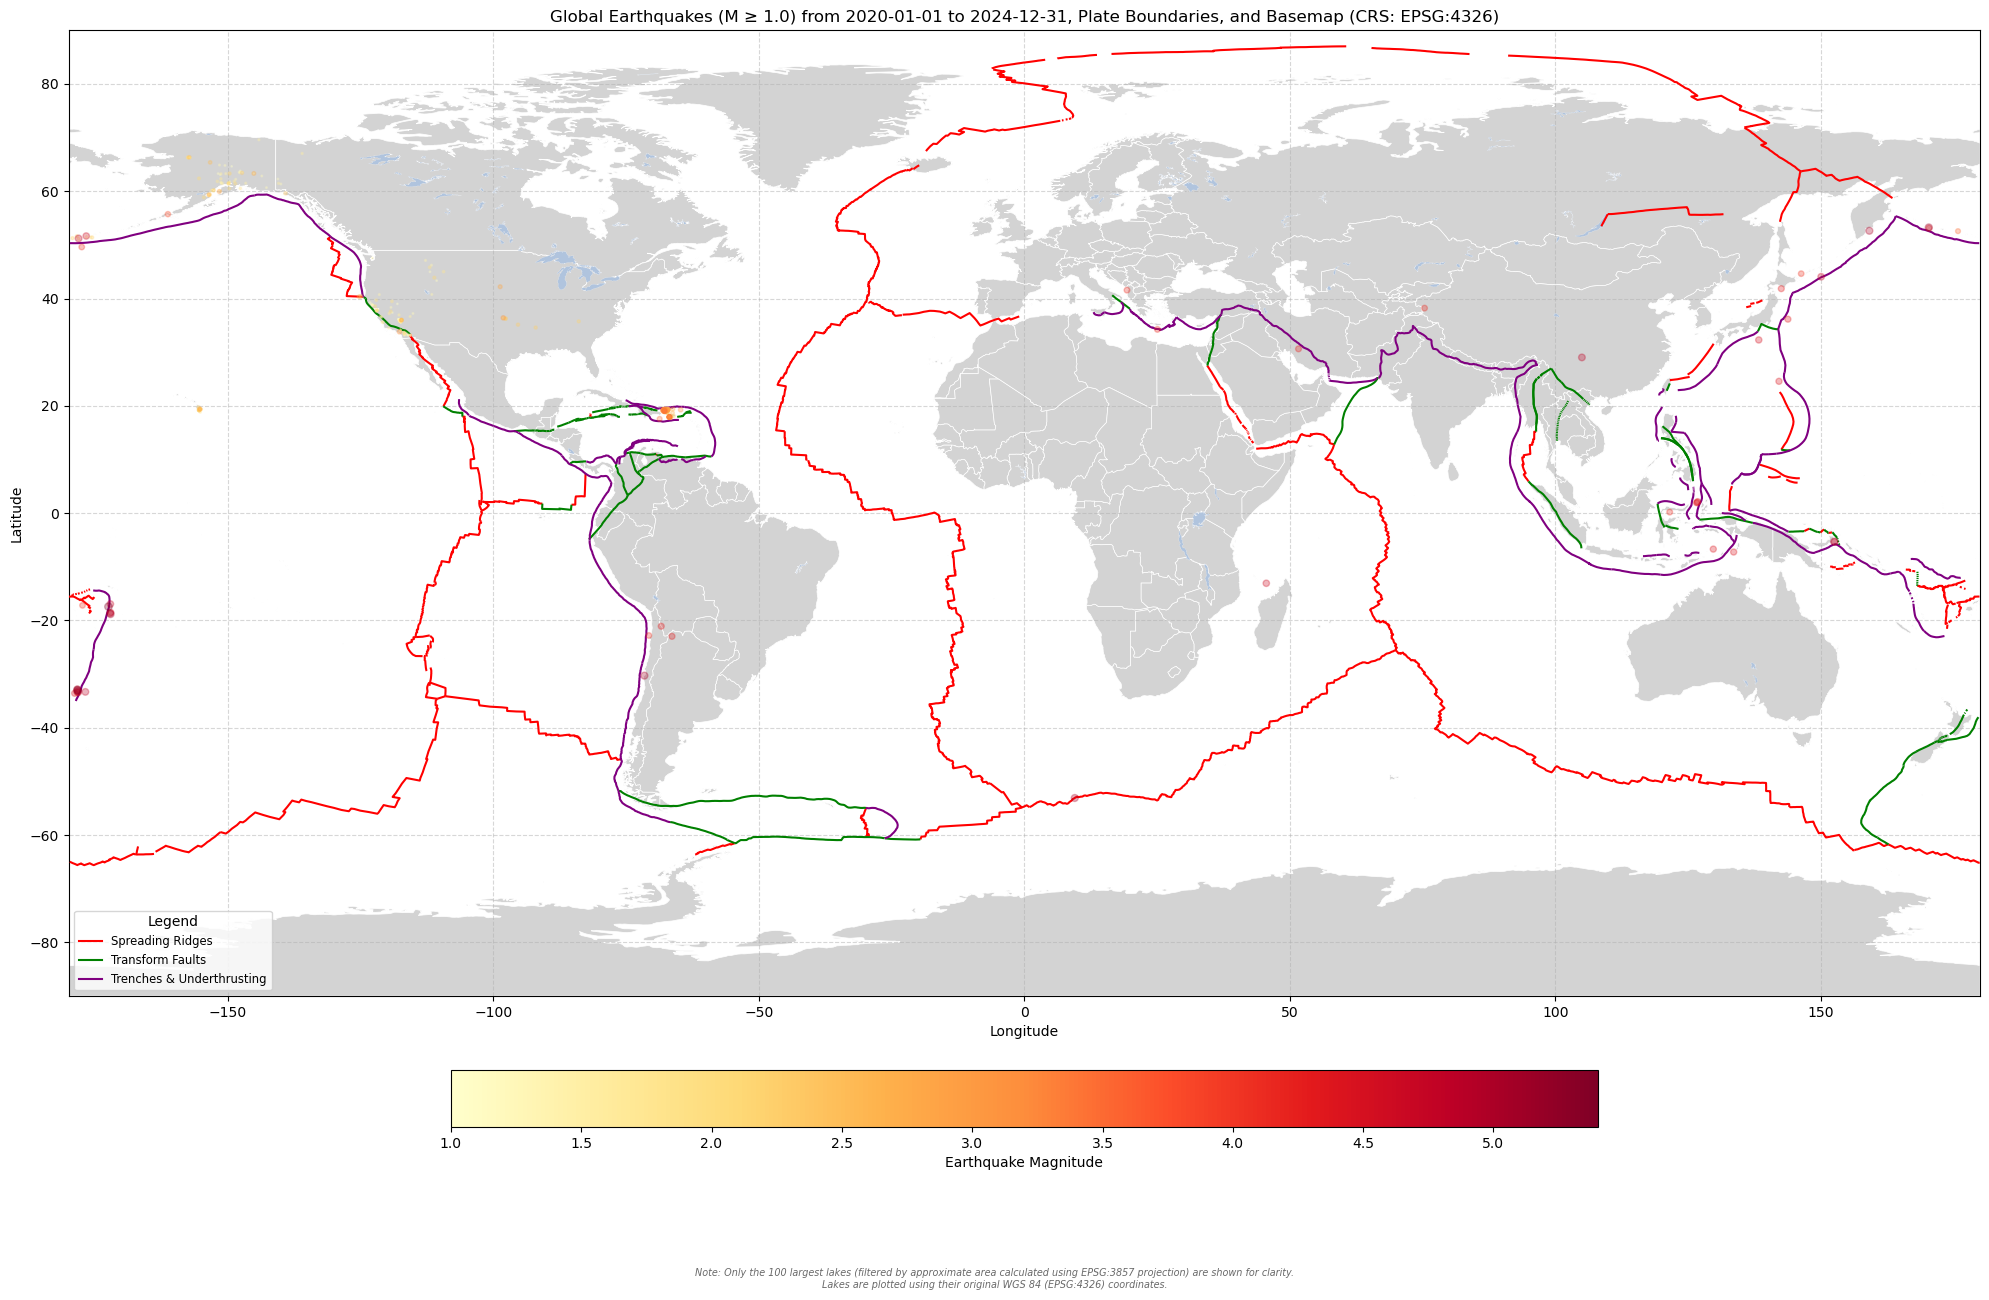

2025-04-08 00:04:29,249 - INFO - Plot displayed.


In [6]:
importlib.reload(functions.plotting) # Using this so I can edit the plotting.py file re-import without having to restart my kernel and load all the data which takes a good deal of time.

if can_plot_plates_eq:
    functions.plotting.plot_earthquake_plate_map( # Ensure using the reloaded module
        earthquake_gdf=earthquake_gdf[:500],
        plate_gdf=plate_gdf,
        ne_land_gdf=ne_countries_gdf, # Pass countries to the renamed parameter
        ne_lakes_gdf=ne_lakes_gdf,
        min_magnitude=min_eq_magnitude,
        start_date=start_date, # Pass the defined start_date (could be None)
        end_date=end_date,     # Pass the defined end_date (could be None)
        target_crs_epsg=target_crs_epsg
    )
else:
    logging.warning("Skipping plot generation due to data loading errors.")